## Transfer Learning with VGG16

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential

In [21]:
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib

In [11]:
import pandas as pd

# Load the Test CSV file
data = pd.read_csv('../../test.csv')
data.head(15)


,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...
5,235 233 223 109 34 37 34 31 28 38 56 69 106 13...
6,71 70 104 147 166 170 195 145 156 154 146 129 ...
7,176 177 170 168 173 171 167 169 166 139 98 107...
8,255 255 255 255 255 255 255 255 255 255 255 25...
9,126 126 123 119 116 113 112 111 110 111 93 72 ...


Test samples have no labels.

In [3]:
data_folder = pathlib.Path('../../facial_expression_recognition/images')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(48, 48),
    label_mode='categorical',
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(48, 48),
    label_mode='categorical',
    batch_size=32)

Found 28821 files belonging to 7 classes.
Found 7066 files belonging to 7 classes.


In [4]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 48, 48, 3)
labels batch shape: (32, 7)


Freeze all layers of VGG16

In [22]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(48, 48, 3))

conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [8]:
from keras import layers

inputs = keras.Input(shape=(48, 48, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation="softmax")(x)
model_3 = keras.Model(inputs, outputs)

In [9]:
opt = keras.optimizers.Nadam(learning_rate=1e-4)
model_3.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/feature_extraction_3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history_3 = model_3.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


901/901 [==============================] - 18s 12ms/step - loss: 18.7691 - accuracy: 0.2436 - val_loss: 6.2553 - val_accuracy: 0.3695
Epoch 2/50
901/901 [==============================] - 10s 11ms/step - loss: 11.6139 - accuracy: 0.2797 - val_loss: 4.6339 - val_accuracy: 0.3909
Epoch 3/50
901/901 [==============================] - 10s 11ms/step - loss: 9.1480 - accuracy: 0.2837 - val_loss: 3.7771 - val_accuracy: 0.3990
Epoch 4/50
901/901 [==============================] - 10s 11ms/step - loss: 7.2880 - accuracy: 0.2917 - val_loss: 3.2059 - val_accuracy: 0.3981
Epoch 5/50
901/901 [==============================] - 10s 11ms/step - loss: 5.9351 - accuracy: 0.2910 - val_loss: 2.6396 - val_accuracy: 0.3997
Epoch 6/50
901/901 [==============================] - 10s 11ms/step - loss: 4.6154 - accuracy: 0.3019 - val_loss: 2.2554 - val_accuracy: 0.4108
Epoch 7/50
901/901 [==============================] - 10s 11ms/step - loss: 3.6602 - accuracy: 0.3053 - val_loss: 2.0371 - val_accuracy: 0.4090
E

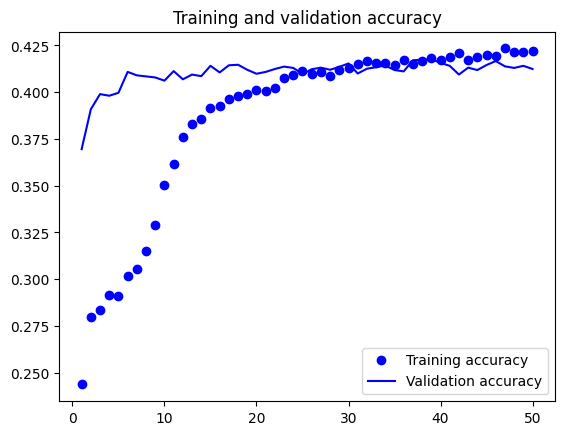

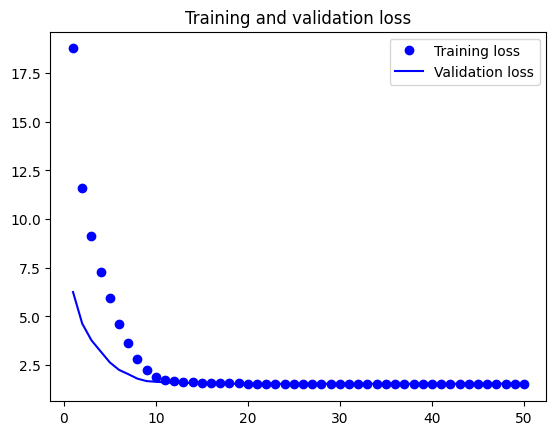

In [31]:
acc = history_3.history["accuracy"]
val_acc = history_3.history["val_accuracy"]
loss = history_3.history["loss"]
val_loss = history_3.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Unfreeze last 4 layers of VGG16

In [25]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(48, 48, 3))

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [29]:
inputs = keras.Input(shape=(48, 48, 3))
x = keras.applications.xception.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(7, activation="softmax")(x)
model_4_layers = keras.Model(inputs, outputs)

In [32]:
model_4_layers.compile(loss="categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/unfreeze_last_4.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model_4_layers.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
901/901 [==============================] - 17s 18ms/step - loss: 1.5711 - accuracy: 0.3896 - val_loss: 1.4007 - val_accuracy: 0.4595
Epoch 2/50
901/901 [==============================] - 16s 18ms/step - loss: 1.2783 - accuracy: 0.5157 - val_loss: 1.2627 - val_accuracy: 0.5246
Epoch 3/50
901/901 [==============================] - 16s 18ms/step - loss: 1.1784 - accuracy: 0.5602 - val_loss: 1.2204 - val_accuracy: 0.5466
Epoch 4/50
901/901 [==============================] - 16s 18ms/step - loss: 1.0979 - accuracy: 0.5933 - val_loss: 1.2462 - val_accuracy: 0.5406
Epoch 5/50
901/901 [==============================] - 16s 17ms/step - loss: 1.0169 - accuracy: 0.6239 - val_loss: 1.3547 - val_accuracy: 0.5197
Epoch 6/50
901/901 [==============================] - 16s 17ms/step - loss: 0.9468 - accuracy: 0.6534 - val_loss: 1.2805 - val_accuracy: 0.5555
Epoch 7/50
901/901 [==============================] - 16s 17ms/step - loss: 0.8771 - accuracy: 0.6809 - val_loss: 1.3588 - val_accuracy: